# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

# Notation

In this notebook we refer to the mini_sparkify_event_data.json as the total dataset

In [1]:
# import libraries
from pyspark.sql import SparkSession, Window
from pyspark import SparkConf, SparkContext

from pyspark.sql.functions import udf, col, lit, min as Fmin, max as Fmax, sum as Fsum, expr, countDistinct
from pyspark.sql.types import IntegerType, DateType, FloatType, DoubleType
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.classification import GBTClassifier, RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import datetime

%matplotlib inline

In [2]:
# create a Spark session

configure = SparkConf() \
    .setAppName("ml_pipelines") \
    .setMaster("local") \
    .set('spark.executor.memory', '6g') \
    .set('spark.driver.memory', '4g') \
    .set('spark.executor.instances', '1') \
    .set('spark.driver.cores', '2')

spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .config(conf=configure) \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
df = spark.read.json('mini_sparkify_event_data.json')
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [4]:
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [5]:
# Before checking for null values, lets get a sense of the size of the dataset

dataset_size = df.count()
print(dataset_size)

286500


In [6]:
# Check for null values in userId and sessionId
print( df.where(col("userId").isNull()).count() )
print( df.where(col("sessionId").isNull()).count() )

0
0


In [7]:
#Check for empty strings in userId and sessionId
print( df.where(col("userId") == "").count() )
print( df.where(col("sessionId") == "").count() )

8346
0


There are 8346 records where the userId is null. This is 2.9% of the total dataset ( mini_sparkify.json ). Lets remove these rows

In [8]:
df = df.filter(df.userId != "")

Nulls in other columns

In [9]:

for c in df.columns:
    null_count_c = df.where(col(c).isNull()).count()
    proportion_null = null_count_c/dataset_size
    print( c + ' : ' + str(null_count_c) + ' : ' + str(proportion_null))

artist : 50046 : 0.1746806282722513
auth : 0 : 0.0
firstName : 0 : 0.0
gender : 0 : 0.0
itemInSession : 0 : 0.0
lastName : 0 : 0.0
length : 50046 : 0.1746806282722513
level : 0 : 0.0
location : 0 : 0.0
method : 0 : 0.0
page : 0 : 0.0
registration : 0 : 0.0
sessionId : 0 : 0.0
song : 50046 : 0.1746806282722513
status : 0 : 0.0
ts : 0 : 0.0
userAgent : 0 : 0.0
userId : 0 : 0.0


Only artist, length and song seem to have nulls and also to the exact same extent. The values are likely null for page visits which dont involve a song like the home page etc.

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

# Basic understanding of data

In [10]:
# Lets look at 2 rows

df.take(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9')]

In [11]:
# Timespan of the data

print( 'Min timestamp = ' + str( datetime.datetime.utcfromtimestamp( df.agg(Fmin(col("ts"))).collect()[0][0]/1000  ).strftime('%c') ) )
print( 'Max timestamp = ' + str( datetime.datetime.utcfromtimestamp( df.agg(Fmax(col("ts"))).collect()[0][0]/1000  ).strftime('%c') ) )

Min timestamp = Mon Oct  1 00:01:57 2018
Max timestamp = Mon Dec  3 01:11:16 2018


In UTC the data given is from 1-Oct-2018 to the early hours of 3-Dec-2018.

Effectively the data given is for a period of 2 months ( 63 days to be precise )

In [12]:
# Number of users

df.select("userId").dropDuplicates().count()

225

In [13]:
# Number of sessions

df.select("sessionId").dropDuplicates().count()

2312

In [14]:
# Distinct values taken by different categorical variables at the app level and their respective number of occurences in the data

# The following fields are excluded here since they are user activity specific. serId, sessionId, artist

categorical_variables = [ 'auth' , 'gender', 'level', 'method', 'page', 'status' ]

for cvar in categorical_variables:
    print(cvar)
#     df.select(cvar).dropDuplicates().sort(cvar).show(100, False)
    df.groupby(cvar).count().sort('count', ascending = False).show(100, False)

auth
+---------+------+
|auth     |count |
+---------+------+
|Logged In|278102|
|Cancelled|52    |
+---------+------+

gender
+------+------+
|gender|count |
+------+------+
|F     |154578|
|M     |123576|
+------+------+

level
+-----+------+
|level|count |
+-----+------+
|paid |222433|
|free |55721 |
+-----+------+

method
+------+------+
|method|count |
+------+------+
|PUT   |257818|
|GET   |20336 |
+------+------+

page
+-------------------------+------+
|page                     |count |
+-------------------------+------+
|NextSong                 |228108|
|Thumbs Up                |12551 |
|Home                     |10082 |
|Add to Playlist          |6526  |
|Add Friend               |4277  |
|Roll Advert              |3933  |
|Logout                   |3226  |
|Thumbs Down              |2546  |
|Downgrade                |2055  |
|Settings                 |1514  |
|Help                     |1454  |
|Upgrade                  |499   |
|About                    |495   |
|Save Sett

In the status field the 404's are interesting and could potentially have a correlation with users dropping out

Most of our events seem to be for listening to the next song

The GET requests are likely for Home page visits etc.

Most events are from paid users

auth=Cancelled seems to refer to users who have cancelled their subscription.

In [15]:
# Number of songs and artists

print( 'Num songs: ' + str(df.select("song").drop_duplicates().count()))
print( 'Num artists: ' + str(df.select("artist").drop_duplicates().count()) )

Num songs: 58481
Num artists: 17656


# Defining churn

We define churn as a user cancelling their service. If we see a "Cancellation Confirmation" event for a user, then we would consider that user to have churned

Given our definition of churn, downgrades of service from paid to free tier could be potential indicators of churn too.

In [16]:
churn = udf(lambda x: int(x == 'Cancellation Confirmation'), IntegerType())
downgrade_churn = udf(lambda x: int(x == 'Submit Downgrade'), IntegerType())

df = df.withColumn("downgraded", downgrade_churn("page")).withColumn("cancelled", churn("page"))

In [17]:
# Lets compute the number of users who downgraded or cancelled

# We first compute the status of each user
signum = udf(lambda x: int(x>0), IntegerType())
# The signum function is used since there are users who have multiple downgrade events.

user_status = df.select(["userId", "downgraded", "cancelled"]) \
    .groupby("userId").sum() \
    .withColumnRenamed("sum(downgraded)" , "sum_downgraded") \
    .withColumnRenamed("sum(cancelled)" , "sum_cancelled") \

user_status = user_status \
    .withColumn('downgraded', signum(col("sum_downgraded"))) \
    .withColumn('cancelled', signum(col("sum_cancelled"))) \
    .drop('sum_downgraded').drop('sum_cancelled')

In [18]:
user_status.show(10)

+------+----------+---------+
|userId|downgraded|cancelled|
+------+----------+---------+
|100010|         0|        0|
|200002|         0|        0|
|   125|         0|        1|
|    51|         0|        1|
|   124|         0|        0|
|     7|         0|        0|
|    54|         1|        1|
|    15|         0|        0|
|   155|         0|        0|
|   132|         0|        0|
+------+----------+---------+
only showing top 10 rows



Its interesting that userId 54 both downgraded and cancelled. Some users seem to have directly cancelled without downgrading.

In [19]:
user_status.agg({ 'downgraded' : 'sum', 'cancelled': 'sum'}).show()

+---------------+--------------+
|sum(downgraded)|sum(cancelled)|
+---------------+--------------+
|             49|            52|
+---------------+--------------+



We have 49 users who downgraded and 52 who cancelled

One must keep in mind that the total number of users is 225. This means 21.7% of users downgraded and 23% cancelled. These numbers are quite high, hence its imperative that we identify these users upfront, address their needs and incentivise them to stay on the platform.

In [20]:
# Of the users who cancelled whats the split of tier of service ( paid/free )

df.filter(df.page == 'Cancellation Confirmation').select(["userId", "level"]).drop_duplicates().groupby("level").count().show()

+-----+-----+
|level|count|
+-----+-----+
| free|   21|
| paid|   31|
+-----+-----+



----------------
  level  count
0  free     21
1  paid     31
----------------


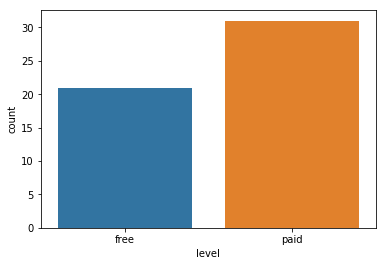

In [21]:
# Of the users who cancelled whats the split of tier of service ( paid/free )

churn_user_split = df.filter(df.page == 'Cancellation Confirmation').select(["userId", "level"]).drop_duplicates().groupby("level").count().toPandas()
print( '----------------')
print( churn_user_split )
print( '----------------')
sns.barplot(x = 'level', y = 'count', data = churn_user_split);

Out of the 52 who cancelled, 21 are free and 31 are paid users

In [22]:
# How many users cancelled without downgrading

user_status.where(col("cancelled") == 1).groupby("downgraded").count().show()

+----------+-----+
|downgraded|count|
+----------+-----+
|         1|    9|
|         0|   43|
+----------+-----+



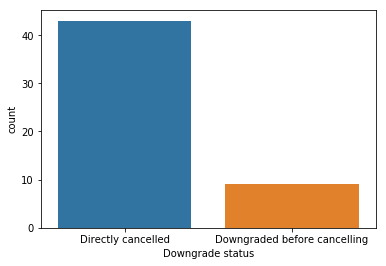

In [23]:
user_status_pd = user_status.toPandas()
fig, ax = plt.subplots(1,1)
sns.countplot( user_status_pd[user_status_pd.cancelled == 1].downgraded, ax = ax )
ax.set_xticklabels(['Directly cancelled', 'Downgraded before cancelling'])
ax.set_xlabel('Downgrade status');

Of the 52 users who cancelled, 43 of them directly cancelled and only 9 of them downgraded before cancelling

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [24]:
# Marking the time and phase of churn for each user
# This will help us find metrics before and after churn for users


window = Window().partitionBy("userId").orderBy("ts").rangeBetween(Window.unboundedPreceding, 0)
df = df.withColumn("churn_phase", Fsum("cancelled").over(window)).withColumn("downgrade_phase", Fsum("downgraded").over(window))

In [25]:
df.where(df.page == "NextSong").select(["userId", "level", "ts"]).groupby( [ "level", "userId" ] ).count().groupby("level").mean().show()

+-----+------------------+
|level|        avg(count)|
+-----+------------------+
| free|215.33846153846153|
| paid|1134.8597560975609|
+-----+------------------+



In [26]:
# Number of songs per session between paid and free

#Lets first compute average number of songs per session for each user

user_avg_songs_per_session = df.where(df.page == "NextSong") \
    .select(["userId", "level", "sessionId"]) \
    .groupby( [ "level", "userId", "sessionId" ] ).count() \
    .withColumnRenamed("count", "numSongsPerSession") \
    .groupby( [ "level", "userId" ] ).agg( { "numSongsPerSession" : "avg"}) \
    .withColumnRenamed("avg(numSongsPerSession)", "avgSongsPerSession")

# Now lets average across all users for free and paid respectively
user_avg_songs_per_session.groupby("level").mean() \
    .withColumnRenamed("avg(avgSongsPerSession)", "avgSongsPerSession") \
    .show()

+-----+------------------+
|level|avgSongsPerSession|
+-----+------------------+
| free| 31.28982093144803|
| paid|102.62525766710827|
+-----+------------------+



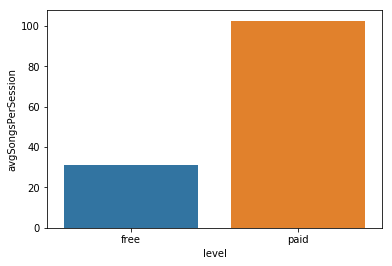

In [27]:
sns.barplot( x = 'level', y = 'avgSongsPerSession', data = user_avg_songs_per_session.groupby("level").mean().withColumnRenamed("avg(avgSongsPerSession)", "avgSongsPerSession").toPandas() );

That is a stark difference. Since ads are played in the free tier, people might listen to lesser songs. Which also means if people dial down their usage due to some reason, then they might have a strong reason to hang on to the subscription. It is possible that people for whom the avg number of songs per session decreases beyond a point, there is a good chance of churn

In [28]:
# Number of songs per day across free and paid

# We first convert the timestamp to date ( in UTC ) and add it to the dataframe

ts_date = udf(lambda x: datetime.datetime.utcfromtimestamp(x/1000), DateType() )
df = df.withColumn("date", ts_date(col("ts")))

#Compute number of songs per day per user

user_avg_songs_per_day = df.where(df.page == "NextSong") \
    .select(["userId", "level", "date"]) \
    .groupby( [ "level", "userId", "date" ] ).count() \
    .withColumnRenamed("count", "numSongsPerDay") \
    .groupby( [ "level", "userId" ] ).agg( { "numSongsPerDay" : "avg"}) \
    .withColumnRenamed("avg(numSongsPerDay)", "avgSongsPerDay")

# Now lets average across all users for free and paid respectively
user_avg_songs_per_day.groupby("level").mean() \
    .withColumnRenamed("avg(avgSongsPerDay)", "avgSongsPerDay") \
    .show()

+-----+------------------+
|level|    avgSongsPerDay|
+-----+------------------+
| free|32.318292019819815|
| paid| 87.08996179115817|
+-----+------------------+



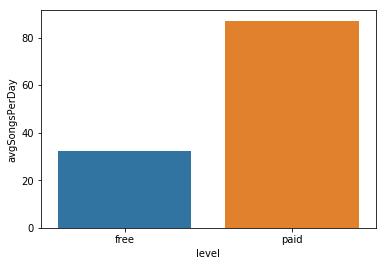

In [29]:
sns.barplot( x = 'level', y = 'avgSongsPerDay', data = user_avg_songs_per_day.groupby("level").mean().withColumnRenamed("avg(avgSongsPerDay)", "avgSongsPerDay").toPandas() );

We observe a similar difference in the average songs per day between paid and free users

In [30]:
# Number of 404s per user

user_pagenotfound = df.filter(df.status == 404).select("userId", "status", "ts").groupby("userId").count().withColumnRenamed("count", "pagenotfound_instances")

user_pagenotfound.agg( Fmax(col("pagenotfound_instances")), Fmin(col("pagenotfound_instances"))  ).show()

+---------------------------+---------------------------+
|max(pagenotfound_instances)|min(pagenotfound_instances)|
+---------------------------+---------------------------+
|                          7|                          1|
+---------------------------+---------------------------+



7 '404' errors in a span of 63 days seems a bit. Lets see what the distribution is like

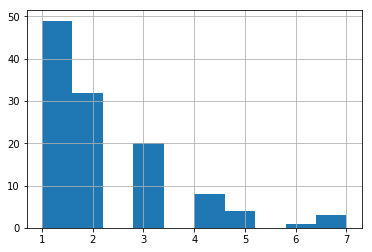

In [31]:
user_pagenotfound.toPandas().pagenotfound_instances.hist();

In [32]:
# Distribution of 404 instances

user_pagenotfound.groupby("pagenotfound_instances").count().sort("pagenotfound_instances").show()

+----------------------+-----+
|pagenotfound_instances|count|
+----------------------+-----+
|                     1|   49|
|                     2|   32|
|                     3|   20|
|                     4|    8|
|                     5|    4|
|                     6|    1|
|                     7|    3|
+----------------------+-----+



Amongst the few users who do see 404 errors, most of them see it only once. The number quickly drops after 3 instances

In [33]:
# Number of errors per user

user_error_pages = df.filter(df.page == "Error").select("userId", "status", "ts").groupby("userId").count().withColumnRenamed("count", "error_instances")

user_error_pages.agg( Fmax(col("error_instances")), Fmin(col("error_instances"))  ).show()

+--------------------+--------------------+
|max(error_instances)|min(error_instances)|
+--------------------+--------------------+
|                   7|                   1|
+--------------------+--------------------+



7 error pages is a lot for 2 months. Lets observe the distribution of the number of error pages

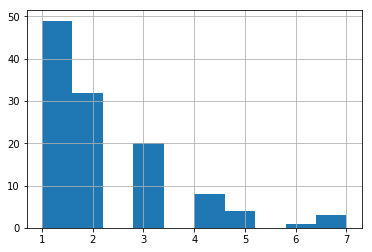

In [34]:
user_error_pages.toPandas().error_instances.hist();

In [35]:
user_error_pages.groupby("error_instances").count().sort("error_instances").show()

+---------------+-----+
|error_instances|count|
+---------------+-----+
|              1|   49|
|              2|   32|
|              3|   20|
|              4|    8|
|              5|    4|
|              6|    1|
|              7|    3|
+---------------+-----+



We see that error and 404 instances have the same distribution. Its very likely that 404s are equivalent to errors. One could prove this using queries, but I will choose to accept this for now.

In [36]:
# Thumbs up and thumbs down per user

user_thumbsup_perday = df.filter(df.page == "Thumbs Up") \
    .select("userId", "date") \
    .groupby( [ "userId", "date" ]) \
    .count() \
    .withColumnRenamed("count", "thumbsup") \
    .groupby("userId").mean() \
    .withColumnRenamed("avg(thumbsup)", "avg_thumbsup_per_day")
    
user_thumbsdown_perday = df.filter(df.page == "Thumbs Down") \
    .select("userId", "date") \
    .groupby( [ "userId", "date" ]) \
    .count() \
    .withColumnRenamed("count", "thumbsdown") \
    .groupby("userId").mean() \
    .withColumnRenamed("avg(thumbsdown)", "avg_thumbsdown_per_day")

/home/karthikv/programming/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


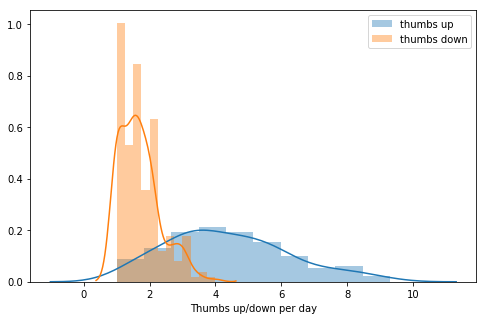

In [37]:
fig,ax = plt.subplots(1,1, figsize = (8,5))
sns.distplot( user_thumbsup_perday.toPandas().avg_thumbsup_per_day, label = 'thumbs up',ax = ax )
sns.distplot( user_thumbsdown_perday.toPandas().avg_thumbsdown_per_day, label = 'thumbs down', ax = ax );
ax.set_xlabel('Thumbs up/down per day')
ax.legend()

In [38]:
# Number of help page visits

user_help_vists = df.filter(df.page == "Help").select("userId", "status", "ts").groupby("userId").count().withColumnRenamed("count", "help_visits")

user_help_vists.agg( Fmax(col("help_visits")), Fmin(col("help_visits"))  ).show()

+----------------+----------------+
|max(help_visits)|min(help_visits)|
+----------------+----------------+
|              46|               1|
+----------------+----------------+



Thats a wide spectrum. Lets see what the distribution is like

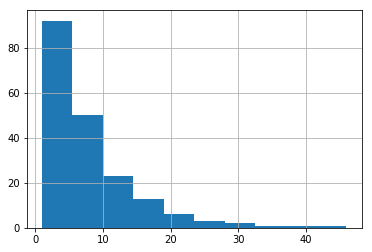

In [39]:
user_help_vists.toPandas().help_visits.hist();

In [40]:
user_help_vists.groupby("help_visits").count().sort("help_visits").show(50)

+-----------+-----+
|help_visits|count|
+-----------+-----+
|          1|   34|
|          2|   19|
|          3|   15|
|          4|   11|
|          5|   13|
|          6|   11|
|          7|   18|
|          8|    7|
|          9|   14|
|         10|    7|
|         11|    2|
|         12|    7|
|         13|    5|
|         14|    2|
|         15|    5|
|         16|    4|
|         17|    2|
|         18|    2|
|         19|    3|
|         20|    1|
|         23|    2|
|         24|    2|
|         27|    1|
|         28|    1|
|         30|    1|
|         34|    1|
|         40|    1|
|         46|    1|
+-----------+-----+



The distribution of help visits is rather skewed towards lower numbers. People who have higher number of help page visits might have a higher propensity to churn

In [41]:
# Number of friend referrals

user_num_friends = df.select(["userId", "page"]) \
    .filter(df.page == "Add Friend") \
    .groupby("userId") \
    .count() \
    .withColumnRenamed("count", "numFriendAdditions")

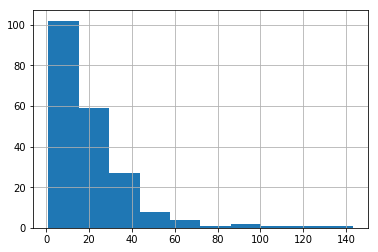

In [42]:
user_num_friends.toPandas().numFriendAdditions.hist();

In [43]:
# Finding last level of users

level_to_int = udf(lambda x: int(x == "paid"), IntegerType())

user_max_ts = df.groupby("userId").agg( { "ts" : "max"} ).withColumnRenamed("max(ts)", "ts")
# user_last_level = user_max_ts.join(  df.select([ "userId", "level", "ts" ]), on  = [ "userId", "ts"], how = "left" ).sort("userId").drop("ts")
user_last_level = user_max_ts.join(  
                            df.select([ "userId", "level", "ts" ]),
                            on  = [ "userId", "ts"],
                            how = "left" 
                        ).sort("userId").drop("ts") \
                        .withColumnRenamed("level","level_string") \
                        .withColumn("level", level_to_int(col("level_string"))) \
                        .drop("level_string")

In [44]:
# Number of days the user has been in the system

compute_duration_days = udf(lambda min_time, max_time : ((max_time - min_time)/(1000*86400)) )
user_days_in_system = df.groupby("userId") \
                        .agg( Fmin(col("ts")).alias("min_ts"), Fmax(col("ts")).alias("max_ts") ) \
                        .withColumn("days_in_system", compute_duration_days(col("min_ts"), col("max_ts"))) \
                        .drop("min_ts").drop("max_ts")

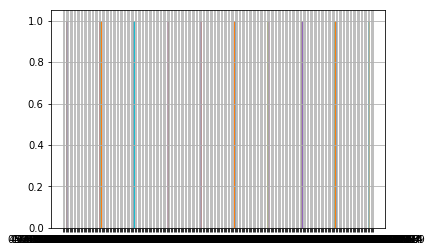

In [45]:
user_days_in_system.toPandas().days_in_system.hist();

In [46]:
# Computing avg pages per session

user_avg_pages_per_session = df.groupby(["userId", "sessionId"]).agg( { "page" : "count"} ).groupby("userId").agg( {"count(page)" : "avg"} ).withColumnRenamed("avg(count(page))", "avg_pages_per_session")

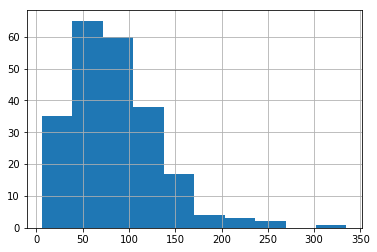

In [47]:
user_avg_pages_per_session.toPandas().avg_pages_per_session.hist();

In [48]:
# Number of advertisement roll outs

user_adverts = df.filter(df.page == "Roll Advert").groupby("userId").count().withColumnRenamed("count", "num_ads")

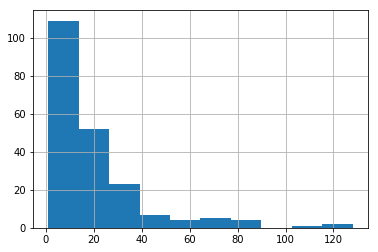

In [49]:
user_adverts.toPandas().num_ads.hist();

In [50]:
# User session length

compute_duration_hours = udf(lambda min_time, max_time : ((max_time - min_time)/(1000*3600)) )
user_avg_session_length = df.groupby([ "userId", "sessionId"] ) \
    .agg( Fmin(col("ts")).alias("min_ts"), Fmax(col("ts")).alias("max_ts") ) \
    .withColumn("session_length", compute_duration_hours(col("min_ts"), col("max_ts"))) \
    .groupby("userId").agg({"session_length":"mean"}) \
    .withColumnRenamed("avg(session_length)", "avg_session_length")    

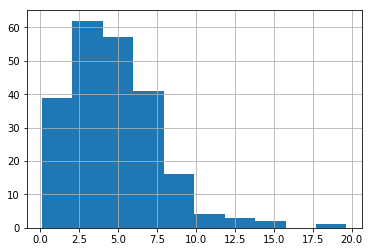

In [51]:
user_avg_session_length.toPandas().avg_session_length.hist();

In [52]:
# Number of additions to the playlist

user_playlist_adds = df.filter(df.page == "Add to Playlist").groupby("userId").count().withColumnRenamed("count", "num_playlist_adds")

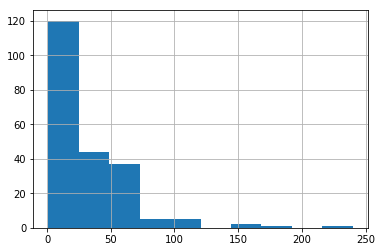

In [53]:
user_playlist_adds.toPandas().num_playlist_adds.hist()

In [54]:
# Number of distinct artists and songs a user listens to

user_num_artists_songs = df.filter(df.page == "NextSong") \
                            .groupby("userId") \
                            .agg( 
                                countDistinct(col("artist") ).alias("num_distinct_artists"), 
                                countDistinct(col("song")).alias("num_distinct_songs")  
                            )

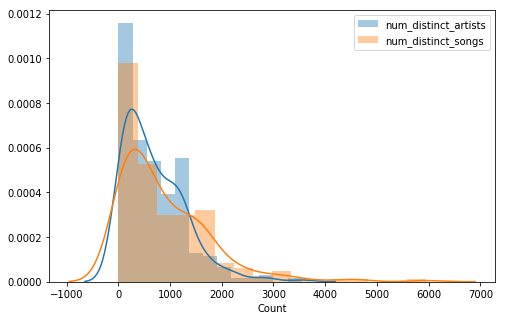

In [55]:
user_num_artists_songs_pd = user_num_artists_songs.toPandas()

fig,ax = plt.subplots(1,1, figsize = (8,5))
sns.distplot( user_num_artists_songs_pd.num_distinct_artists, label = 'num_distinct_artists',ax = ax )
sns.distplot( user_num_artists_songs_pd.num_distinct_songs, label = 'num_distinct_songs', ax = ax );
ax.set_xlabel('Count')
ax.legend()

In [56]:
# Abstract the data fetching from disk and basic cleanup into a function

def obtain_data(filepath):
    '''
    Given a file path:
    
    1. Read the events json file
    2. Remove records with null or empty string userId's and sessionId's
    '''
    df = spark.read.json(filepath=filepath)
    df = df.where( (df.userId.isNotNull()) & (df.sessionId.isNotNull()) & (df.userId != "") & (df.sessionId != "") )
    return df    

# Combine all the feature engineering and put in a single function

def feature_engineering(events_df):
    '''
    Given an events spark data frame, compute the necessary features for
    predicting churn using machine learning algorithms
    
    Inputs:
        events_df: Spark data frame with the structure        
         |-- artist: string (nullable = true)
         |-- auth: string (nullable = true)
         |-- firstName: string (nullable = true)
         |-- gender: string (nullable = true)
         |-- itemInSession: long (nullable = true)
         |-- lastName: string (nullable = true)
         |-- length: double (nullable = true)
         |-- level: string (nullable = true)
         |-- location: string (nullable = true)
         |-- method: string (nullable = true)
         |-- page: string (nullable = true)
         |-- registration: long (nullable = true)
         |-- sessionId: long (nullable = true)
         |-- song: string (nullable = true)
         |-- status: long (nullable = true)
         |-- ts: long (nullable = true)
         |-- userAgent: string (nullable = true)
         |-- userId: string (nullable = true)            
    
    Output:
        df_feature: Spark data frame with the following structure
        root
         |-- userId: string (nullable = true)
         |-- downgraded: integer (nullable = true)
         |-- cancelled: integer (nullable = true)
         |-- avgSongsPerSession: double (nullable = true)
         |-- avgSongsPerDay: double (nullable = true)
         |-- avg_thumbsup_per_day: double (nullable = true)
         |-- avg_thumbsup_per_day: double (nullable = true)
         |-- error_instances: long (nullable = false)
         |-- help_visits: long (nullable = false)
         |-- numFriendAdditions: long (nullable = false)
    '''
    
    churn = udf(lambda x: int(x == 'Cancellation Confirmation'), IntegerType())
    downgrade_churn = udf(lambda x: int(x == 'Submit Downgrade'), IntegerType())    
    signum = udf(lambda x: int(x>0), IntegerType())
    ts_date = udf(lambda x: datetime.datetime.utcfromtimestamp(x/1000), DateType() )
    proportion = udf(lambda x,y : x/y, FloatType())
    
    ## Base transformations to input df
    events_df = events_df.withColumn("date", ts_date(col("ts")))       
       
    ## User level features    
    
    # Status of each user ( target variable )
    user_status = events_df.select(["userId", "downgraded", "cancelled"]) \
        .groupby("userId").sum() \
        .withColumnRenamed("sum(downgraded)" , "sum_downgraded") \
        .withColumnRenamed("sum(cancelled)" , "sum_cancelled") \

    user_status = user_status \
        .withColumn('downgraded', signum(col("sum_downgraded"))) \
        .withColumn('cancelled', signum(col("sum_cancelled"))) \
        .drop('sum_downgraded').drop('sum_cancelled')
    # The signum function is used since there are users who have multiple downgrade events.
        
    #Number of songs per session per user
    user_avg_songs_per_session = events_df.where(events_df.page == "NextSong") \
        .select(["userId", "sessionId"]) \
        .groupby( [ "userId", "sessionId" ] ).count() \
        .withColumnRenamed("count", "numSongsPerSession") \
        .groupby( [ "userId" ] ).agg( { "numSongsPerSession" : "avg"}) \
        .withColumnRenamed("avg(numSongsPerSession)", "avgSongsPerSession")
    
    #Number of songs per day per user
    user_avg_songs_per_day = events_df.where(events_df.page == "NextSong") \
        .select(["userId", "date"]) \
        .groupby( [ "userId", "date" ] ).count() \
        .withColumnRenamed("count", "numSongsPerDay") \
        .groupby( [ "userId" ] ).agg( { "numSongsPerDay" : "avg"}) \
        .withColumnRenamed("avg(numSongsPerDay)", "avgSongsPerDay")
    
    #Number of thumbs ups per day per user
    user_thumbsup_perday = events_df.filter(events_df.page == "Thumbs Up") \
        .select("userId", "date") \
        .groupby( [ "userId", "date" ]) \
        .count() \
        .withColumnRenamed("count", "thumbsup") \
        .groupby("userId").mean() \
        .withColumnRenamed("avg(thumbsup)", "avg_thumbsup_per_day")
    
    #Number of thumbs down per day per user
    user_thumbsdown_perday = events_df.filter(events_df.page == "Thumbs Down") \
        .select("userId", "date") \
        .groupby( [ "userId", "date" ]) \
        .count() \
        .withColumnRenamed("count", "thumbsdown") \
        .groupby("userId").mean() \
        .withColumnRenamed("avg(thumbsdown)", "avg_thumbsdown_per_day")    

    #Number of error pages encountered by user
    user_error_pages = events_df.filter(events_df.page == "Error") \
        .select("userId", "status", "ts") \
        .groupby("userId") \
        .count() \
        .withColumnRenamed("count", "error_instances")
    
    # Number of help page visits
    user_help_vists = events_df.filter(events_df.page == "Help") \
        .select("userId", "status", "ts") \
        .groupby("userId") \
        .count() \
        .withColumnRenamed("count", "help_visits")
    
    # Number of friend additions per user
    user_num_friends = events_df.select(["userId", "page"]) \
        .filter(df.page == "Add Friend") \
        .groupby("userId") \
        .count() \
        .withColumnRenamed("count", "numFriendAdditions")
    
    # Finding last level of users
    level_to_int = udf(lambda x: int(x == "paid"), IntegerType())
    user_max_ts = events_df \
                    .groupby("userId").agg( { "ts" : "max"} ) \
                    .withColumnRenamed("max(ts)", "ts")
    user_last_level = user_max_ts.join(  
                            df.select([ "userId", "level", "ts" ]),
                            on  = [ "userId", "ts"],
                            how = "left" 
                        ).sort("userId").drop("ts") \
                        .withColumnRenamed("level","level_string") \
                        .withColumn("level", level_to_int(col("level_string"))) \
                        .drop("level_string")    
    
    # Number of days the user has been in the system

    compute_duration_days = udf(lambda min_time, max_time : ((max_time - min_time)/(1000*86400)), DoubleType() )
    user_days_in_system = events_df.groupby("userId") \
                            .agg( 
                                Fmin(col("ts")).alias("min_ts"), 
                                Fmax(col("ts")).alias("max_ts") ) \
                            .withColumn(
                                "days_in_system", 
                                compute_duration_days(col("min_ts"), col("max_ts")) ) \
                            .drop("min_ts").drop("max_ts")
    
    # Computing avg pages per session
    user_avg_pages_per_session = events_df.groupby(["userId", "sessionId"]) \
                                    .agg( { "page" : "count"} ) \
                                    .groupby("userId") \
                                    .agg( {"count(page)" : "avg"} ) \
                                    .withColumnRenamed("avg(count(page))", "avg_pages_per_session")
    
    
    # Number of advertisement roll outs per user
    user_adverts = events_df.filter(events_df.page == "Roll Advert") \
                        .groupby("userId").count() \
                        .withColumnRenamed("count", "num_ads")
    
    # User session length
    compute_duration_hours = udf(lambda min_time, max_time : ((max_time - min_time)/(1000*3600)), DoubleType() )
    user_avg_session_length = events_df.groupby([ "userId", "sessionId"] ) \
                                .agg( Fmin(col("ts")).alias("min_ts"), Fmax(col("ts")).alias("max_ts") ) \
                                .withColumn("session_length", compute_duration_hours(col("min_ts"), col("max_ts"))) \
                                .groupby("userId").agg({"session_length":"mean"}) \
                                .withColumnRenamed("avg(session_length)", "avg_session_length")
    
    # Number of additions to the playlist
    user_playlist_adds = events_df.filter(events_df.page == "Add to Playlist") \
                            .groupby("userId").count() \
                            .withColumnRenamed("count", "num_playlist_adds")
    
    # Number of distinct artists and songs a user listens to

    user_num_artists_songs = events_df.filter(events_df.page == "NextSong") \
                                .groupby("userId") \
                                .agg( 
                                    countDistinct(col("artist") ).alias("num_distinct_artists"), 
                                    countDistinct(col("song")).alias("num_distinct_songs")  
                                )
        
    df_features = user_status \
        .join(user_avg_songs_per_session, on = "userId" , how = 'left') \
        .join(user_avg_songs_per_day, on = "userId", how = 'left') \
        .join(user_thumbsup_perday, on = "userId", how = 'left') \
        .join(user_thumbsdown_perday, on = "userId", how = 'left') \
        .join(user_error_pages, on = "userId", how = 'left') \
        .join(user_help_vists, on = "userId", how = 'left') \
        .join(user_num_friends, on = "userId", how = 'left') \
        .join(user_last_level, on = "userId", how = "left") \
        .join(user_days_in_system, on = "userId", how = "left") \
        .join(user_avg_pages_per_session, on = "userId", how = "left") \
        .join(user_adverts, on = "userId", how = "left") \
        .join(user_avg_session_length, on = "userId", how = "left") \
        .join(user_playlist_adds, on = "userId", how = "left") \
        .join(user_num_artists_songs, on = "userId", how = "left")
    
    # Renaming the target column to label and casting it to DoubleType
    df_features = df_features.withColumn( "label", df_features.cancelled.cast(DoubleType())).drop("cancelled")
    df_features = df_features.drop_duplicates()
    
    return df_features

In [57]:
def feature_scaling(df_features):
    feature_cols = df_features.drop('userId', 'label').columns
    #Replace nulls with zero for columns in feature_cols
    df_features = df_features.fillna(0, subset = feature_cols )
    
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="FeatureVector")
    df_features = assembler.transform(df_features)
    
    scaler = StandardScaler(withMean = True, inputCol = "FeatureVector",  outputCol = "ScaledFeatureVector")
    scalerModel = scaler.fit(df_features)
    df_features = scalerModel.transform(df_features)
    df_features_scaled = df_features.select(["userId", "label", "ScaledFeatureVector"])    
    
    return df_features_scaled

In [58]:
df_features = feature_engineering(df)

In [59]:
df_features_scaled = feature_scaling(df_features)

In [60]:
df_features_scaled.persist()

DataFrame[userId: string, label: double, ScaledFeatureVector: vector]

In [61]:
df_features_scaled.show(10, False)

+------+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userId|label|ScaledFeatureVector                                                                                                                                                                                                                                                                                                               |
+------+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [62]:
df_features_scaled.count()

# We have a row for each user in our dataset

225

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

## Train test split

In [63]:
train, validation = df_features_scaled.randomSplit([0.70, 0.30], seed = 42)

Lets see the distribution of churned an non-churned users in both the training and validation sets

In [64]:
train.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|  127|
|  1.0|   36|
+-----+-----+



In [65]:
validation.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|   46|
|  1.0|   16|
+-----+-----+



In both datasets about 22-25% of the users have churned

## Functions for find the best threshold and evaluating a given model

In [66]:
def find_best_threshold_by_f1_score(preds, labelCol = 'label', probabilityCol = 'probability', steps = 1000):
    '''
        Given prediction probabilities by a classiification model, find the best threshold that maximizes fscore
        
        Input:
            preds - Spark dataframe with the following schema            
             |-- userId: string (nullable = true)
             |-- label: double (nullable = true)
             |-- ScaledFeatureVector: vector (nullable = true)
             |-- rawPrediction: vector (nullable = true)
             |-- probability: vector (nullable = true)
             |-- prediction: double (nullable = false)
        
        Output:
            best_threshold - Best threshold in [0,1] that maximizes fscore
            best_fscore - Best fscore achieved using the best_threshold
    '''
    labels = preds[labelCol]
    probability = preds[probabilityCol]
    fscores = []
    thresholds = np.linspace(0,1,steps)
    
    for thresh in thresholds:
        pred_labels = probability.apply(lambda x: np.float64(x > thresh))
        fscores.append( f1_score(labels, pred_labels) )
    
    return ( thresholds[ np.argmax(fscores) ], np.max(fscores) )

In [67]:
def evaluate_model(model, train, validation):
    '''
    Input:
        ML model after fitting
        
        Given a model we find the best threshold that gives the best f-score on the valdation data set
        Then we take this best threshold and apply that on the model predictions of the test data set.
        On this set set of predictions on the test set we compute precision, recall, f-score etc.
        
        We also compute area under the ROC curve for train, validation and test datasets
    
    Output:
        Metrics:
            AUC for train, validation and test            
            Best threshold based on validation
            FScore using best threshold on validation, test            
    '''
    
    model_preds_train = model.transform(train)
    model_preds_valid = model.transform(validation)
    
    evaluator_roc = BinaryClassificationEvaluator(metricName = 'areaUnderROC')
    auc_train = evaluator_roc.evaluate(model_preds_train)
    auc_valid = evaluator_roc.evaluate(model_preds_valid)
    
    model_preds_train_df = model_preds_train.select( [ 'userId', 'label', 'probability', 'prediction' ] ).toPandas()
    
    model_train_fscore = f1_score( model_preds_train_df.label, model_preds_train_df.prediction)
    model_train_precision = precision_score( model_preds_train_df.label, model_preds_train_df.prediction)
    model_train_recall = recall_score( model_preds_train_df.label, model_preds_train_df.prediction)
    model_train_accuracy = accuracy_score( model_preds_train_df.label, model_preds_train_df.prediction)
    
    model_preds_valid_df = model_preds_valid.select( [ 'userId', 'label', 'probability', 'prediction' ] ).toPandas()  
    
    model_valid_fscore = f1_score( model_preds_valid_df.label, model_preds_valid_df.prediction)
    model_valid_precision = precision_score( model_preds_valid_df.label, model_preds_valid_df.prediction)
    model_valid_recall = recall_score( model_preds_valid_df.label, model_preds_valid_df.prediction)
    model_valid_accuracy = accuracy_score( model_preds_valid_df.label, model_preds_valid_df.prediction)    
    
    metrics = {
        'train_auc' : auc_train,
        'valid_auc' : auc_valid,        
        'train_precision' : model_train_precision,
        'train_recall' : model_train_recall,
        'train_fscore' : model_train_fscore,
        'train_accuracy': model_train_accuracy,        
        'valid_precision' : model_valid_precision,
        'valid_recall' : model_valid_recall,
        'valid_fscore' : model_valid_fscore,
        'valid_accuracy': model_valid_accuracy
    }
    
    return metrics  

## Experimenting with different classifiers

### Random forest classifier

In [68]:
%%time
# Random forest classifier
rf = RandomForestClassifier(
        featuresCol = "ScaledFeatureVector", 
        labelCol = 'label', 
        maxMemoryInMB = 1000, 
        seed = 42,

    )
rf_model = rf.fit(train)

CPU times: user 168 ms, sys: 80 ms, total: 248 ms
Wall time: 30.6 s


In [69]:
rf_model_metrics = evaluate_model(rf_model, train, validation)

In [70]:
rf_model_metrics

{'train_auc': 0.993766404199475,
 'valid_auc': 0.8552989130434782,
 'train_precision': 1.0,
 'train_recall': 0.8611111111111112,
 'train_fscore': 0.9253731343283582,
 'train_accuracy': 0.9693251533742331,
 'valid_precision': 0.875,
 'valid_recall': 0.4375,
 'valid_fscore': 0.5833333333333334,
 'valid_accuracy': 0.8387096774193549}

%%time
# Random forest classifier
rf = RandomForestClassifier(
        featuresCol = "ScaledFeatureVector", 
        labelCol = 'label', 
        maxMemoryInMB = 1000, 
        seed = 42,
        numTrees = 20,
        minInstancesPerNode = 1,
        maxDepth = 5,
        featureSubsetStrategy = "0.6",
        subsamplingRate = 0.8
    )
rf_model = rf.fit(train)
rf_model_metrics = evaluate_model(rf_model, train, validation)

### Gradient boosted tree classifier

In [71]:
%%time
# Gradient boosted trees classifier
gbt = GBTClassifier(
        featuresCol = "ScaledFeatureVector", 
        labelCol = 'label', 
        maxMemoryInMB = 1000, 
        seed = 42        
    )
gbt_model = gbt.fit(train)

CPU times: user 3.06 s, sys: 716 ms, total: 3.78 s
Wall time: 5min 8s


In [72]:
gbt_model_metrics = evaluate_model(gbt_model, train, validation)

In [73]:
gbt_model_metrics

{'train_auc': 0.9998906386701661,
 'valid_auc': 0.75,
 'train_precision': 1.0,
 'train_recall': 0.9722222222222222,
 'train_fscore': 0.9859154929577464,
 'train_accuracy': 0.9938650306748467,
 'valid_precision': 0.5,
 'valid_recall': 0.4375,
 'valid_fscore': 0.4666666666666667,
 'valid_accuracy': 0.7419354838709677}

### Logistic regression

In [74]:
%%time

lr = LogisticRegression(featuresCol = "ScaledFeatureVector")
lr_model = lr.fit(train)

CPU times: user 2.6 s, sys: 668 ms, total: 3.27 s
Wall time: 3min 37s


In [75]:
lr_model_metrics = evaluate_model(lr_model, train, validation)

In [76]:
lr_model_metrics

{'train_auc': 0.9359142607174112,
 'valid_auc': 0.830163043478261,
 'train_precision': 0.8125,
 'train_recall': 0.7222222222222222,
 'train_fscore': 0.7647058823529411,
 'train_accuracy': 0.901840490797546,
 'valid_precision': 0.7142857142857143,
 'valid_recall': 0.3125,
 'valid_fscore': 0.43478260869565216,
 'valid_accuracy': 0.7903225806451613}

In all these models we can observe heavy overfitting. The train f-scores are mugh higher than their validation counterparts

Lets tune the parameters of the models and try to reduce the overfitting using cross validation

### Random forest classifier with hyper parameter tuning

In [77]:
%%time
# Random forest with cross validation
rf_paramGrid = ParamGridBuilder() \
    .addGrid( rf.numTrees, [20, 30]) \
    .addGrid( rf.featureSubsetStrategy, [ "auto", "1.0" ]) \
    .build()

crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=rf_paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName = 'f1'),
                          numFolds=3,
                          seed=50)
rf_cv_model = crossval.fit(train)

CPU times: user 3.83 s, sys: 1.08 s, total: 4.9 s
Wall time: 7min 17s


In [78]:
rf_cv_model_metrics = evaluate_model(rf_cv_model, train, validation)

In [79]:
rf_cv_model_metrics

{'train_auc': 0.9983595800524934,
 'valid_auc': 0.8491847826086956,
 'train_precision': 0.9714285714285714,
 'train_recall': 0.9444444444444444,
 'train_fscore': 0.9577464788732395,
 'train_accuracy': 0.9815950920245399,
 'valid_precision': 0.8333333333333334,
 'valid_recall': 0.625,
 'valid_fscore': 0.7142857142857143,
 'valid_accuracy': 0.8709677419354839}

In [80]:
# lets see what parameters the best model took

rf_cv_model.bestModel.extractParamMap()

{Param(parent='RandomForestClassifier_a86ba5ce3af6', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='RandomForestClassifier_a86ba5ce3af6', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='RandomForestClassifier_a86ba5ce3af6', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): '1.0',
 Param(parent='RandomForestClassifier_a86ba5ce3af6', name='featuresCol', doc='features column name'): 'ScaledFeatureVector',
 Param(parent='RandomForestClassifier_a86ba

### Gradient boosted tree classifier with hyper parameter tuning

In [81]:
%%time
# Gradient boosted trees with cross validation
gbt_paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [3,5]) \
    .addGrid(gbt.minInstancesPerNode, [5, 15] ) \
    .build()

gbt_crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=gbt_paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

gbt_cv_model = gbt_crossval.fit(train)

CPU times: user 34.4 s, sys: 8.94 s, total: 43.3 s
Wall time: 52min 53s


In [82]:
gbt_cv_model_metrics = evaluate_model(gbt_cv_model, train, validation)

In [83]:
gbt_cv_model_metrics

{'train_auc': 0.9797681539807523,
 'valid_auc': 0.8620923913043477,
 'train_precision': 0.8529411764705882,
 'train_recall': 0.8055555555555556,
 'train_fscore': 0.8285714285714286,
 'train_accuracy': 0.9263803680981595,
 'valid_precision': 0.6153846153846154,
 'valid_recall': 0.5,
 'valid_fscore': 0.5517241379310345,
 'valid_accuracy': 0.7903225806451613}

In [84]:
# Lets see what the best models parameters
gbt_cv_model.bestModel.extractParamMap()

{Param(parent='GBTClassifier_f0287cbf5f3e', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='GBTClassifier_f0287cbf5f3e', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='GBTClassifier_f0287cbf5f3e', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'all',
 Param(parent='GBTClassifier_f0287cbf5f3e', name='featuresCol', doc='features column name'): 'ScaledFeatureVector',
 Param(parent='GBTClassifier_f0287cbf5f3e', name='labelCol', doc='label column 

### Logistic regression  with hyper parameter tuning

In [85]:
%%time
# Logistic regression with cross validation
lr_paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.0, 0.1, 0.5, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.05, 0.1] ) \
    .build()

lr_crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=lr_paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

lr_cv_model = lr_crossval.fit(train)

CPU times: user 36.3 s, sys: 9.72 s, total: 46 s
Wall time: 48min 13s


In [86]:
lr_cv_model_metrics = evaluate_model(lr_cv_model, train, validation)

In [87]:
lr_cv_model_metrics

{'train_auc': 0.9359142607174112,
 'valid_auc': 0.830163043478261,
 'train_precision': 0.8125,
 'train_recall': 0.7222222222222222,
 'train_fscore': 0.7647058823529411,
 'train_accuracy': 0.901840490797546,
 'valid_precision': 0.7142857142857143,
 'valid_recall': 0.3125,
 'valid_fscore': 0.43478260869565216,
 'valid_accuracy': 0.7903225806451613}

## Comparing different models

In [88]:
all_metrics = pd.DataFrame( { 
    'Base RF': rf_model_metrics, 
    'CV RF' : rf_cv_model_metrics, 
    'Base GBT' : gbt_model_metrics, 
    'CV GBT' : gbt_cv_model_metrics,
    'Base LR' : lr_model_metrics,
    'CV LR' : lr_cv_model_metrics
}).sort_index()
all_metrics

,Base RF,CV RF,Base GBT,CV GBT,Base LR,CV LR
train_accuracy,0.969325,0.981595,0.993865,0.926380,0.901840,0.901840
train_auc,0.993766,0.998360,0.999891,0.979768,0.935914,0.935914
train_fscore,0.925373,0.957746,0.985915,0.828571,0.764706,0.764706
train_precision,1.000000,0.971429,1.000000,0.852941,0.812500,0.812500
train_recall,0.861111,0.944444,0.972222,0.805556,0.722222,0.722222
valid_accuracy,0.838710,0.870968,0.741935,0.790323,0.790323,0.790323
valid_auc,0.855299,0.849185,0.750000,0.862092,0.830163,0.830163
valid_fscore,0.583333,0.714286,0.466667,0.551724,0.434783,0.434783
valid_precision,0.875000,0.833333,0.500000,0.615385,0.714286,0.714286
valid_recall,0.437500,0.625000,0.437500,0.500000,0.312500,0.312500


## Best model

The tuned Random Forest is the best performing model when comparing all the moels using validation fscore. The tuned model overfits considerably lesser compared to the base random forest model with default parameters.

Lets see features are important for the tuned random forest model

In [102]:
feature_cols = df_features.columns
feature_cols.remove('userId')
feature_cols.remove('label')
feature_cols

['downgraded',
 'avgSongsPerSession',
 'avgSongsPerDay',
 'avg_thumbsup_per_day',
 'avg_thumbsdown_per_day',
 'error_instances',
 'help_visits',
 'numFriendAdditions',
 'level',
 'days_in_system',
 'avg_pages_per_session',
 'num_ads',
 'avg_session_length',
 'num_playlist_adds',
 'num_distinct_artists',
 'num_distinct_songs']

In [103]:
pd.DataFrame( 
    list( rf_cv_model.bestModel.featureImportances ), 
    index = feature_cols, 
    columns = ['feature importance'] ).sort_values('feature importance', ascending = False)

,feature importance
days_in_system,0.414831
num_ads,0.104205
num_playlist_adds,0.101041
avgSongsPerSession,0.086476
numFriendAdditions,0.078146
avg_thumbsdown_per_day,0.048378
avg_thumbsup_per_day,0.033698
num_distinct_artists,0.033530
avgSongsPerDay,0.028438
avg_pages_per_session,0.019879


The number of days a user has been in the system seems to be most important feature to the model, followed by number of advertisements they heard and the number of times they added songs to a playlist.

This could mean many users come check out the service for some time and then leave after a while. Sparkify needs to question what provide long term value to its users and provide them such features

## Potential improvements

1. Run the analysis on the full data set of 12GB

Here we have only used the small 128MB subset of the full 12GB data. I would like to run the same analysis on the full dataset to see how the results hold. Very importantly one begins to see the power of spark only in that scale of data

2. Reduce overfitting

Most models trained above still have a considerable gap between the train f-score and validation f-score. One needs to dig deeper as to why this is happening. One possible reason is that there are correlated features being used. Though non-linear methods should be robust to correlated features, there might still be some effect.

3. Build better features

We could build more fine grained features. For example is a user upgraded and downgraded their service, we consider those two time periods the same and features consider the total or the average across both those time periods. However their behaviour in those 2 time periods could be very different and this should be reflected in the features we build.